In [15]:
# import tensorflow as tf

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

2023-11-28 15:15:02.474728: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 15:15:02.601732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 15:15:02.601789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 15:15:02.601993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 15:15:02.669126: I tensorflow/core/platform/cpu_feature_g

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8255406858459715518
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5607784448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5354920088878964614
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2023-11-28 15:15:04.983286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 15:15:05.062046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 15:15:05.062072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 15:15:06.974827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 15:15:06.975009: I tensorflow/compile

In [2]:
# os.chdir("/mnt/")
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/Annaantonin/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


In [5]:
# rm -rf Data

In [4]:
import Data as data
data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [9]:
os.listdir(".")

['dataset',
 'README.md',
 'dist',
 'build',
 'output.mat',
 'examples',
 'NeuralUQ.egg-info',
 'output_ukF.mat',
 '.git',
 'setup.py',
 'Data',
 'neuraluq']

In [76]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise_x, noise_f):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sdof_2000.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train.T, t_train.T, x_train.T, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x):
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constrains for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)  [0][..., 0:1]         #velocity                                                                                                                                                                                                                   
    x_tt = tf.gradients(x_t, t)  [0][..., 0:1]  

    f = tf.multiply(x_tt, 5.0)+ tf.multiply(x_t, 0.22) * x_t + tf.multiply(x, 10)
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return f

def pde_xtt(t,x,xtt):
    x_t = tf.gradients(x, t)     #[0][..., 0:1]                                                                                                                                                                                                                    
    x_tt = tf.gradients(x_t, t)  #[0][..., 0:1] 

    return x_tt-xtt
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
    
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement
    # )
         # posterior=neuq_vars.fnn.Trainable(
         #    layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)
        # ),
    )
    process_xtt = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement

    )
    # process_log_c = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.const.Trainable(value=0),
    # )
    # process_log_k = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.const.Trainable(value=0),
    # )
    method = neuq.inferences.DEns(
        num_samples=1, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-2),
    )

    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=np.zeros_like(t_train), # could be the problem
        processes=[process_x, process_xtt],
        pde=pde_xtt, # dotdot _X
        multiplier=1.0,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=f_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x], # tf train
        pde=pde_fn,
        multiplier=0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_xtt],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x,process_xtt]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise, noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1,50,50, 1]

    processes, samples, model = Trainable( x_tt_train, t_train, x_train, f_train, noise, layers,
    )

    x_pred, xtt_pred = model.predict(t_train, samples, processes, pde_fn=None)


2023-11-28 16:12:18.820094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 16:12:18.820175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 16:12:18.820186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 16:12:18.820656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 16:12:18.820682: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-11-28 16:12:19.247400: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_105/Assign' id:9641 op device:{requested: '', assigned: ''} def:{{{node Variable_105/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_105, zeros_52)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  2.478455
Iteration:  1000 , loss:  5.357683e-07
Iteration:  2000 , loss:  1.012817e-07
Iteration:  3000 , loss:  2.2524928e-08
Iteration:  4000 , loss:  1.9225752e-06
Iteration:  5000 , loss:  3.556952e-08
Iteration:  6000 , loss:  1.8458843e-08
Iteration:  7000 , loss:  1.9659263e-08
Iteration:  8000 , loss:  2.4695469e-08
Iteration:  9000 , loss:  6.165118e-09
Execution time for 'Trainable' function is: 20.563 s, 0.343 mins


In [ ]:
# neuq.utils.plot1d(t_train,x_train,t_train,x_train,  x_pred[:, :, 0])

Text(0.5, 1.0, 'acceleration')

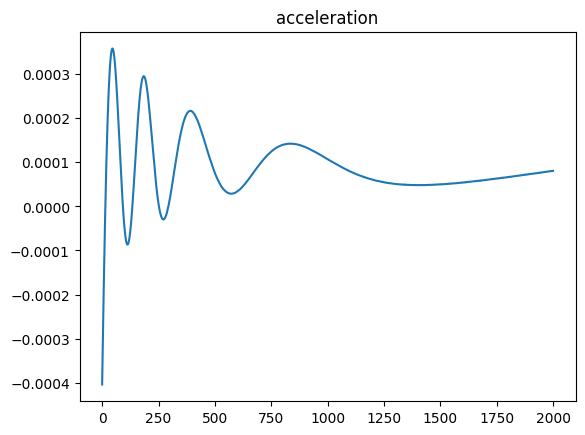

In [83]:
len(xtt_pred)
plt.plot(xtt_pred[0].flatten())
plt.title('acceleration')

Text(0.5, 1.0, 'displacement')

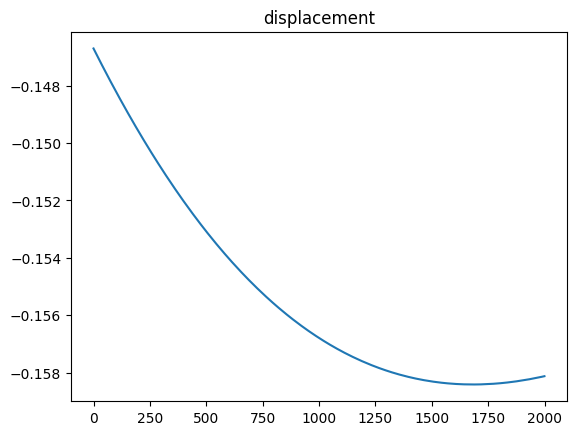

In [84]:
plt.plot(x_pred[0].flatten())
plt.title('displacement')

In [ ]:
# [a.shape for a in samples]
noise = 0
x_tt_train, t_train, x_train, f_train = load_data(noise, noise)
x= tf.convert_to_tensor(x_train)
t=tf.convert_to_tensor(t_train)
x_t = tf.gradients(x, t)
xx= np.array(x_t)
plt.plot(xx.T)
# /x_tt = tf.gradients(x_t, t)

In [24]:
x_tt_train, t_train, x_train, f_train = load_data(noise, noise)
x=x_train
t=t_train

In [ ]:
# (x_pred,) = model.predict(t_train, samples, processes, pde_fn=None)
x_pred, xtt_pred = model.predict(t_train, samples, processes, pde_fn=None)
# plt.plot(t_train,np.mean(x_pred,axis=(0,2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()

plt.plot(xtt_pred)
# plt.plot(x_pred[0].flatten())
# plt.plot(t_train,x_pred[0].flatten(),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()

TypeError: list indices must be integers or slices, not tuple

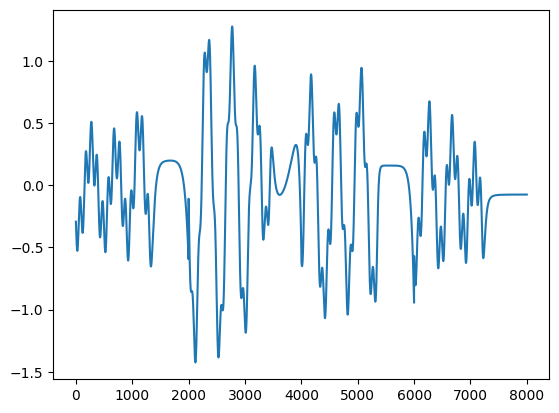

In [56]:
plt.plot(x_pred[0].flatten())
x=x_pred[0].flatten()
plt.plot(x_pred[3,0])
# plt.plot(x_train,'r',label='Actual displacement')

<module 'tensorflow.compat.v1.version' from '/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/compat/v1/version/__init__.py'>


In [50]:
# x_train.shape
len(x_pred.[0])

SyntaxError: invalid syntax (3014919491.py, line 2)

In [ ]:
plt.plot(x_tt_train)

In [ ]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)

In [ ]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [4]:
Csamp=samples[6]    
Ksamp=samples[7]
C_post=np.exp(np.mean(Csamp))
print("C_true=0.22(Ns/m) and C_post =", C_post) 
K_post=np.exp(np.mean(Ksamp))
print("K_true=10(N/m) and K_post =", K_post) 

C_true=0.22(Ns/m) and C_post = 2.0725696
K_true=10(N/m) and K_post = 91.10976


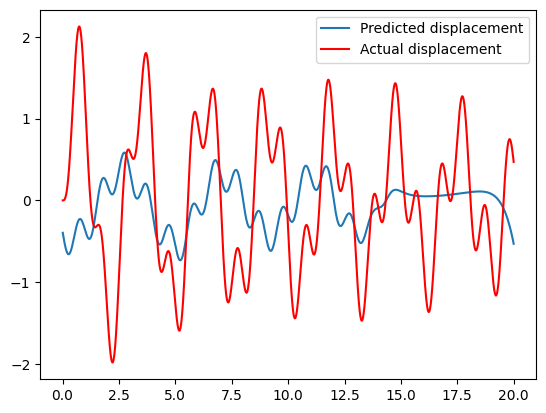

In [61]:
plt.plot(t_train,np.mean(x_pred,axis=(0,2)),label='Predicted displacement')
plt.plot(t_train,x_train,'r',label='Actual displacement')
plt.legend()

In [ ]:
# sio.savemat("G:/My Drive/Python_codes/sdof0.mat", {"x_pred":x_pred, "k":samples[7].flatten(),"c":samples[6].flatten()})

In [24]:
# data_to_save = {
#    "x_pred":x_pred, "c":samples[6].flatten(),"k":samples[7].flatten()
# }
# file_name = 'output.mat'
# sio.savemat(file_name, data_to_save)

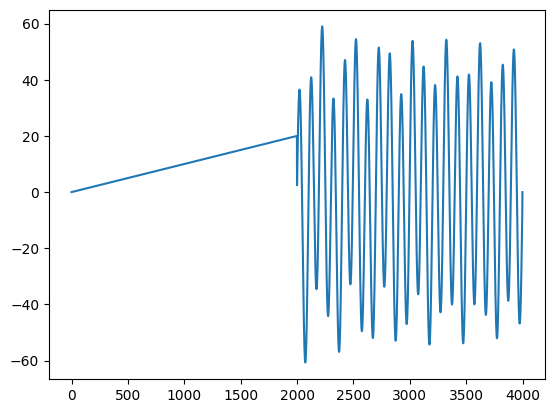

In [34]:
Input_train=np.vstack((t_train,x_tt_train))
plt.plot(Input_train)       

In [36]:
x_pred.shape


AttributeError: 'list' object has no attribute 'shape'

In [89]:
inputs=np.concatenate([t_train, x_tt_train], axis=-1)


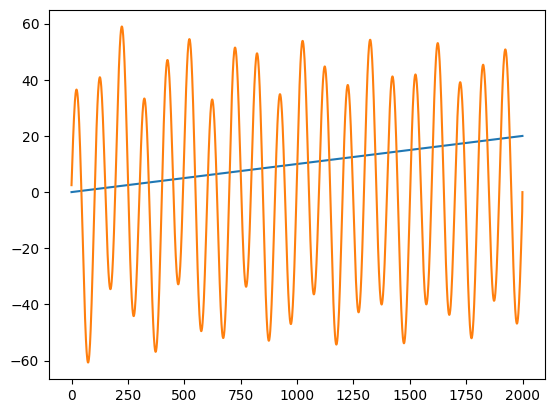

In [90]:
plt.plot(inputs)